# Feedback Prize - Predicting Effective Arguments

When I checked other notebooks on Kaggle I notice BERT is very popular. In stead of BERT I will use Universal Sentence Encoder with triple inputs. I saw this kind of build in Tensorflow Course of https://www.kaggle.com/mrdbourke. Since, I am at the start of my Data Science journey all, positive or negative feedbacks are appreciated about anything within the notebook.


## imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import string
from tensorflow.keras import layers
from tensorflow_hub import KerasLayer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


## Getting data

In [2]:
train = pd.read_csv("drive/MyDrive/Datasets/Feedback_Prize/train.csv")
test = pd.read_csv("drive/MyDrive/Datasets/Feedback_Prize/test.csv")

In [3]:
display(train.head(), test.head())

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


## EDA

In [63]:
# Check shapes
print(f"Shape of Training data {train.shape}")
print(f"Shape of Test data {test.shape}")
# Number of unique essay count
print(f"Number of unique essay count: {train.essay_id.nunique()}")

Shape of Training data (33112, 6)
Shape of Test data (10, 6)
Number of unique essay count: 3772


In [68]:
# Check a random essay
ran_uniq_id = random.choice(train.essay_id.unique())
for i in (train["discourse_text"].loc[train["essay_id"] == ran_uniq_id]):
  print(i)

school is the last place a student wants to be in when theyve experienced a couple of rough days or even weeks and home is the first place they think about when they need comfort or rest similarly not all students are carbon copies different students require different paces regarding social life and acdemics so why would schools reject the needs of their variety of students 
students should have access to long distance learning where they will attend classes online and where they will study in a safe familiar environment that they already perform better in as place they can focus 
firstly the internet and modern technologys first purpose is to make our lives better 
this is the direction the todays world is headed teachers loath the phrase i forgot it at home but with the ease of online classes students will not be able to use the same excuses teachers also will not have to worry about misplaced papers when all of the materials will be conveniently saved online 
but some opponents beli

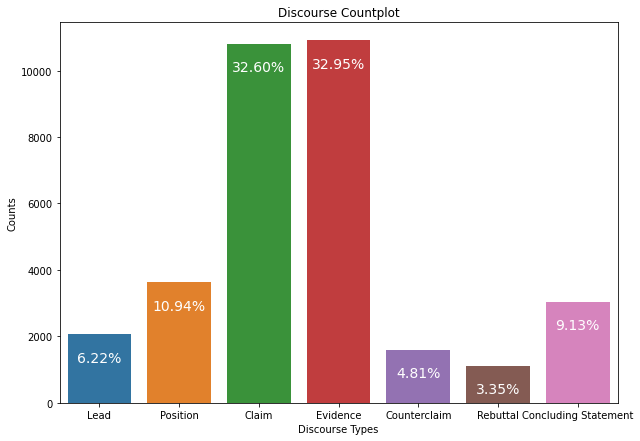

In [78]:
# Visualize unique Discourse types
plt.figure(figsize = (10,7))
ax = sns.countplot(x = train["discourse_type"])
for p in ax.patches:
    percentage = str(f"{(100 * p.get_height()/len(train)):.2f}") + "%"
    ax.annotate(f'\n{percentage}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)

plt.title("Discourse Countplot")
plt.ylabel("Counts")
plt.xlabel("Discourse Types");

### Target Investigation

In [79]:
# How many disclosure types?
print(f"Count of discourse_effectiveness types: {train.discourse_effectiveness.nunique()}\n")
print(f"discourse_effectiveness types are: {train.discourse_effectiveness.unique()}")

Count of discourse_effectiveness types: 3

discourse_effectiveness types are: ['Adequate' 'Ineffective' 'Effective']


In [81]:
# How many disclosure types?
print(f"Count of discourse_effectiveness types: {train.discourse_effectiveness.nunique()}\n")
print(f"discourse_effectiveness types are: {train.discourse_effectiveness.unique()}")

Count of discourse_effectiveness types: 3

discourse_effectiveness types are: ['Adequate' 'Ineffective' 'Effective']


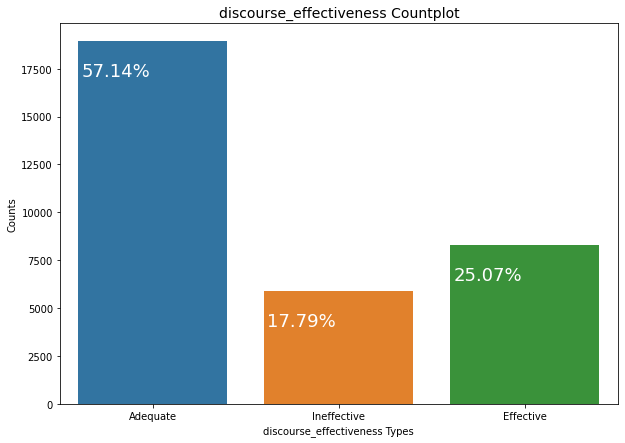

In [83]:
# Visualize unique discourse_effectiveness types
plt.figure(figsize = (10,7))
ax = sns.countplot(x = train["discourse_effectiveness"])
for p in ax.patches:
    percentage = str(f"{(100 * p.get_height()/len(train)):.2f}") + "%"
    ax.annotate(f'\n{percentage}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.title("discourse_effectiveness Countplot", fontsize = 14)
plt.ylabel("Counts")
plt.xlabel("discourse_effectiveness Types");

## Feature Engineering
Since `discourse_text` constructed as sentence splits of essays. In my opinion order of texts is important within same `essay_id`. Let's add line_num to our data

In [4]:
train["line_num"] = train.groupby("essay_id")["essay_id"].cumcount()+1
test["line_num"] = test.groupby("essay_id")["essay_id"].cumcount()+1
display(train.head(11))

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,line_num
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,3
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,4
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,5
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,6
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,7
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,8
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,9
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,1


## Preprocessing 
Steps:
  * Lower the text
  * Remove digits
  * Remove Punctuation 

In [5]:
def preprocess_text(data):
  for i, text in enumerate(data["discourse_text"]):
      text =  text.lower()
      text = text.translate(str.maketrans("", "", string.digits))
      text = text.translate(str.maketrans("", "", string.punctuation))
      data["discourse_text"][i] = text  

In [6]:
preprocess_text(train), preprocess_text(test), display(train.head(), test.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,line_num
0,0013cc385424,007ACE74B050,hi im isaac im going to be writing about how t...,Lead,Adequate,1
1,9704a709b505,007ACE74B050,on my perspective i think that the face is a n...,Position,Adequate,2
2,c22adee811b6,007ACE74B050,i think that the face is a natural landform be...,Claim,Adequate,3
3,a10d361e54e4,007ACE74B050,if life was on mars we would know by now the r...,Evidence,Adequate,4
4,db3e453ec4e2,007ACE74B050,people thought that the face was formed by ali...,Counterclaim,Adequate,5


,discourse_id,essay_id,discourse_text,discourse_type,line_num
0,a261b6e14276,D72CB1C11673,making choices in life can be very difficult p...,Lead,1
1,5a88900e7dc1,D72CB1C11673,seeking multiple opinions can help a person ma...,Position,2
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim,3
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim,4
4,93578d946723,D72CB1C11673,can be very helpful and beneficial,Claim,5


(None, None, None)

## Splitting train dataset into train and val 
Since in my opinion order of essays are important I will split dataset but will keep same essay elements together.

In [7]:
# Make Train And Val Split
np.random.seed(42)
split_size = int(0.1 * train["essay_id"].nunique()) # Split size 
random_id = random.sample(list(train["essay_id"].unique()), split_size) # choose random sample from unique ids 
is_val = np.isin(train.essay_id, random_id) # returns boolean list are these samples in d
idxs = np.arange(len(train))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
val = train.iloc[val_idxs]
train = train.iloc[trn_idxs]
train.shape, val.shape

((33112, 6), (3653, 6))

## Preparing for Multi Input Functional API

### Label


In [8]:
# OneHotEncode, Target data
ohe = OneHotEncoder(sparse = False)
train_labels_ohe = ohe.fit_transform(train.discourse_effectiveness.to_numpy().reshape(-1,1))
val_labels_ohe = ohe.fit_transform(val.discourse_effectiveness.to_numpy().reshape(-1,1))



### Token

In [9]:
# Create sentence var for Token
train_sentences = train.discourse_text
val_sentences = val.discourse_text
test_sentences = test.discourse_text
train_sentences[:5]

0    hi im isaac im going to be writing about how t...
1    on my perspective i think that the face is a n...
2    i think that the face is a natural landform be...
3    if life was on mars we would know by now the r...
4    people thought that the face was formed by ali...
Name: discourse_text, dtype: object

In [10]:
# Download and load pretrained Universal Sentence Encoder
large_embed = KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                       input_shape = [],
                       dtype = tf.string,
                       trainable = False,
                       name = "USE")

### line_num

In [11]:
# Check 98% percentile of line_num
line_num_98perc = np.percentile(train.line_num, 98)
line_num_98perc

14.0

In [12]:
# OneHotEncode line_num 

train_line_ohe = tf.one_hot(train.line_num.to_numpy(), depth = line_num_98perc)
val_line_ohe = tf.one_hot(val.line_num.to_numpy(), depth = line_num_98perc)
test_line_ohe = tf.one_hot(test.line_num.to_numpy(), depth = line_num_98perc)

### discourse_type


In [57]:
# OneHotEncode discourse_type
le = LabelEncoder()
train_distype_ohe = ohe.fit_transform(train.discourse_type.to_numpy().reshape(-1,1))
val_distype_ohe = ohe.fit_transform(val.discourse_type.to_numpy().reshape(-1,1))
test_distype_ohe = tf.one_hot(le.fit_transform(test.discourse_type), depth= 7)


### Let's Combine and Create tf.data

In [60]:
# Train dataset
train_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                 train_line_ohe,
                                                 train_distype_ohe))
train_label = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_dataset = tf.data.Dataset.zip((train_data, train_label)).batch(32).prefetch(tf.data.AUTOTUNE)

# Val Dataset
val_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                 val_line_ohe,
                                                 val_distype_ohe))
val_label = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_dataset = tf.data.Dataset.zip((val_data, val_label)).batch(32).prefetch(tf.data.AUTOTUNE)

# Test Dataset
test_dataset = [np.array(test_sentences), np.array(test_line_ohe), np.array(test_distype_ohe)] 

## Building quadruple input model with Functional API


In [15]:
# Token Model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embed = large_embed(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embed)
token_model = tf.keras.Model(token_inputs, token_output)


# line_num Model
line_input = layers.Input(int(line_num_98perc,), dtype = tf.float32, name = "line_num_model")
line_output = layers.Dense(128, activation = "relu")(line_input)
line_model = tf.keras.Model(line_input, line_output)

# type Model
type_input = layers.Input(shape = (7,), dtype = tf.float64, name = "type_model")
type_output = layers.Dense(128, activation = "relu")(type_input)
type_model = tf.keras.Model(type_input,type_output)

# Concatenate all add dropout
z = layers.Concatenate()([token_model.output,
                        line_model.output,
                        type_model.output])

z = layers.Dense(256,activation = "relu")(z)

# output
model_output = layers.Dense(3, activation = "softmax")(z)

# Create model
model = tf.keras.Model([token_model.input,
                        line_model.input,
                        type_model.input],
                       model_output)

# Model Comple
model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


In [16]:
# Fit the model
history_model = model.fit(train_dataset,
                          steps_per_epoch = 200, 
                          epochs = 5,
                          validation_data = val_dataset)

Epoch 1/5
200/200 [==============================] - 61s 167ms/step - loss: 0.8529 - accuracy: 0.6142 - val_loss: 0.8343 - val_accuracy: 0.6422
Epoch 2/5
200/200 [==============================] - 27s 135ms/step - loss: 0.7829 - accuracy: 0.6431 - val_loss: 0.8470 - val_accuracy: 0.6354
Epoch 3/5
200/200 [==============================] - 25s 125ms/step - loss: 0.8120 - accuracy: 0.6381 - val_loss: 0.7866 - val_accuracy: 0.6545
Epoch 4/5
200/200 [==============================] - 24s 122ms/step - loss: 0.8043 - accuracy: 0.6403 - val_loss: 0.7682 - val_accuracy: 0.6644
Epoch 5/5
200/200 [==============================] - 26s 129ms/step - loss: 0.7735 - accuracy: 0.6503 - val_loss: 0.7672 - val_accuracy: 0.6655


In [17]:
# Evaluate on val_dataset
model.evaluate(val_dataset)

115/115 [==============================] - 10s 86ms/step - loss: 0.7672 - accuracy: 0.6655


[0.7671899199485779, 0.6654804348945618]

In [91]:
# Predict on dummified test dataset
preds = model.predict(test_dataset)
preds

array([[0.6249582 , 0.2001147 , 0.17492707],
       [0.57884675, 0.3763547 , 0.04479856],
       [0.4205305 , 0.5471592 , 0.03231025],
       [0.47225028, 0.46337327, 0.06437641],
       [0.35747603, 0.6178139 , 0.02471006],
       [0.1511378 , 0.8461433 , 0.00271885],
       [0.12537955, 0.87224346, 0.002377  ],
       [0.29659575, 0.6843073 , 0.01909694],
       [0.1557727 , 0.8416939 , 0.00253344],
       [0.2976338 , 0.69790334, 0.00446295]], dtype=float32)

In [84]:
# Save Model
model.save("3_input_model.h5")

In [85]:
# Check Sample Submission
sample_sub = pd.read_csv('drive/MyDrive/Datasets/Feedback_Prize/sample_submission.csv')
sample_sub.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [90]:
# Create submisson csv 
my_submission = pd.DataFrame({
    "discourse_id": test.discourse_id,
    "Ineffective": preds[:,0],
    "Adequate": preds[:,1],
    "Effective": preds[:,2]
})
my_submission

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.624958,0.200115,0.174927
1,5a88900e7dc1,0.578847,0.376355,0.044799
2,9790d835736b,0.420530,0.547159,0.032310
3,75ce6d68b67b,0.472250,0.463373,0.064376
4,93578d946723,0.357476,0.617814,0.024710
5,2e214524dbe3,0.151138,0.846143,0.002719
6,84812fc2ab9f,0.125380,0.872243,0.002377
7,c668ff840720,0.296596,0.684307,0.019097
8,739a6d00f44a,0.155773,0.841694,0.002533
9,bcfae2c9a244,0.297634,0.697903,0.004463


In [ ]:
my_submission.to_csv('submission.csv',index=False)